# **Building Keras pipelines for CIFAR-10**


(c) Devika Subramanian, 2021

## **Workflow**

- Step 0: Install/import needed packages (keras, sklearn)
- Step 1: Get CIFAR-10 data: split into training, validation, test data
- Step 2: Visualize data (check for quality/outliers)
- Step 3: Prepare the data for the Keras pipeline
- Step 4: Build model (pipeline)
    - Design the model
    - Fit the parameters of the model
    - Monitor training process to check for overfitting (visualize training)
- Step 5: Evaluate model
- Step 6: Interpret model
    - analyze classification errors
    - salience analysis to understand model (OPTIONAL/EXTRA CREDIT)

## **Step 0: Install/import all needed packages**

In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets 

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score

import pandas as pd
import numpy as np
import random
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger

#from imutils import paths
import shutil
import cv2
import os

## **Step 1: Get CIFAR-10 data**
- split data into training, validation and testing sets

In [3]:
(Xtrain, ytrain), (Xtest, ytest) = tensorflow.keras.datasets.cifar10.load_data()
ytrain = ytrain.flatten()
ytest = ytest.flatten()
print('Xtrain shape = ', Xtrain.shape)
print('Xtest shape = ', Xtest.shape)
print('ytrain shape = ', ytrain.shape)
print('ytest shape = ', ytest.shape)

170500096/170498071 [==============================] - 11s 0us/step
Xtrain shape =  (50000, 32, 32, 3)
Xtest shape =  (10000, 32, 32, 3)
ytrain shape =  (50000,)
ytest shape =  (10000,)


## **Step 2: Visualize data**

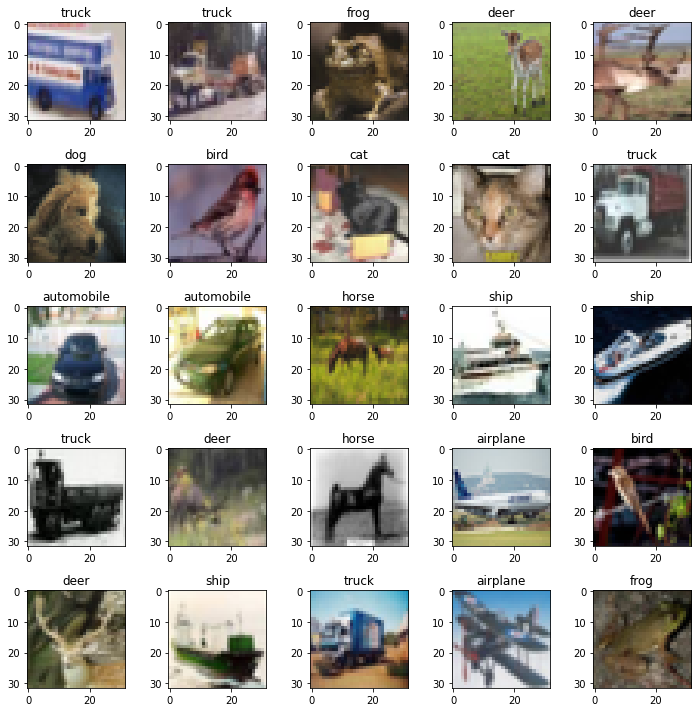

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
def plot_cifar10(X,y):  
  plt.figure(figsize=(10, 10))
  samples = np.array([np.random.randint(0,X.shape[0]) for _ in range(25)])
  for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(X[samples[i]], cmap='gray', interpolation='none')
        plt.title(class_names[y[samples[i]]])
  plt.tight_layout()

plot_cifar10(Xtrain,ytrain)

## **Step 3: Prepare data for the pipeline** (5 points)
- Input images to be reshaped and scaled
    - our network is going to take a color image of size 32x32 as a training example: first cast Xtrain, Xtest to float32
    - the input pixels have values in the range [0-255], scale them to have values in the range [0,1] (divide by 255)
- Output labels to be one-hot coded 
   - use the to_categorical function in tensorflow.keras.utils

- Print the shapes of Xtrain, Xtest, ytrain and ytest (you should see the following shapes)
     - Xtrain shape =  (50000, 32, 32, 3)
     - Xtest shape =  (10000, 32, 32, 3)
     - ytrain shape =  (50000, 10)
     - ytest shape =  (10000, 10)

In [5]:
# 6 lines (not including prints)
def scale(X):
    X = X.astype('float32')
    X/=255
    return X

Xtrains = scale(Xtrain)
Xtests = scale(Xtest)

print("Xtrain shape = ", Xtrains.shape)
print("Xtest shape = ", Xtests.shape)

ytrains = to_categorical(ytrain, 10)
ytests = to_categorical(ytest, 10)

print("ytrain shape = ", ytrains.shape)
print("ytest shape = ", ytests.shape)

Xtrain shape =  (50000, 32, 32, 3)
Xtest shape =  (10000, 32, 32, 3)
ytrain shape =  (50000, 10)
ytest shape =  (10000, 10)


## **Step 4a: Build model** (10 points)

Build the following sequential model 
   - Input layer (shape = (32,32,3)
   - Conv 2D layer with 32 kernels, each of size (3,3) and relu activation with he_uniform kernel_initializer
   - Conv 2D layer with 32 kernels, each of size (3,3) and relu activation with he_uniform kernel_initializer
   - MaxPooling layer with pool size (2,2)
   - Dropout layer with probability 0.2
   - Conv 2D layer with 64 kernels, each of size (3,3) and relu activation with he_uniform kernel_initializer
   - Conv 2D layer with 64 kernels, each of size (3,3) and relu activation with he_uniform kernel_initializer
   - MaxPooling layer with pool size (2,2)
   - Dropout layer with probability 0.2
   - Conv 2D layer with 128 kernels, each of size (3,3) and relu activation with he_uniform kernel_initializer
   - Conv 2D layer with 128 kernels, each of size (3,3) and relu activation with he_uniform kernel_initializer
   - MaxPooling layer with pool size (2,2)
   - Dropout layer with probability 0.2
   - Flatten layer
   - Dense layer with 128 units and relu activation
   - Dropout layer with 0.2 probability
   - Dense layer with 10 units with softmax activation (output layer)

In [6]:
# define model_cnn here
model_cnn = Sequential(
    [
        Input(shape=(32,32,3)),
        Conv2D(32, 3, activation='relu', kernel_initializer="he_uniform", padding='same'),
        Conv2D(32, 3, activation='relu', kernel_initializer="he_uniform", padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        Conv2D(64, 3, activation='relu', kernel_initializer="he_uniform", padding='same'),
        Conv2D(64, 3, activation='relu', kernel_initializer="he_uniform", padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        Conv2D(128, 3, activation='relu', kernel_initializer="he_uniform", padding='same'),
        Conv2D(128, 3, activation='relu', kernel_initializer="he_uniform", padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        Flatten(),
        Dense(128,activation='relu'),
        Dropout(0.2),
        Dense(10,activation="softmax")
    ]
)
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

## **Step 4b: Specify training parameters** (5 points)
- loss function (categorical crossentropy)
- optimizer (adam)
- metrics to track during training (accuracy) (called 'acc')

In [7]:
# 1 line of code
model_cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc'])

## **Step 4c: Fit model parameters with training data** (5 points)
- specify training X,y
- batch size (64)
- number of training epochs (15)
- verbose (1)
- validation_split (0.1)

In [8]:
# 1 line of code
model_cnn.fit(Xtrains, ytrains,
         batch_size = 64, epochs = 15, 
         verbose = 1, validation_split = 0.1)

Epoch 1/15
704/704 [==============================] - 37s 8ms/step - loss: 2.0009 - acc: 0.2552 - val_loss: 1.2821 - val_acc: 0.5324
Epoch 2/15
704/704 [==============================] - 5s 7ms/step - loss: 1.2910 - acc: 0.5343 - val_loss: 0.9379 - val_acc: 0.6618
Epoch 3/15
704/704 [==============================] - 5s 7ms/step - loss: 1.0256 - acc: 0.6370 - val_loss: 0.8106 - val_acc: 0.7130
Epoch 4/15
704/704 [==============================] - 5s 7ms/step - loss: 0.8697 - acc: 0.6961 - val_loss: 0.7226 - val_acc: 0.7496
Epoch 5/15
704/704 [==============================] - 5s 7ms/step - loss: 0.7741 - acc: 0.7308 - val_loss: 0.7844 - val_acc: 0.7314
Epoch 6/15
704/704 [==============================] - 5s 8ms/step - loss: 0.7124 - acc: 0.7506 - val_loss: 0.6705 - val_acc: 0.7724
Epoch 7/15
704/704 [==============================] - 5s 7ms/step - loss: 0.6530 - acc: 0.7726 - val_loss: 0.6058 - val_acc: 0.7976
Epoch 8/15
704/704 [==============================] - 5s 7ms/step - loss: 0

## **Step 4d: Visualize training performance**
- plot accuracy and loss for train/validation sets
- code assumes your model is called model_cnn
- run the cell below and leave the plots in your notebook

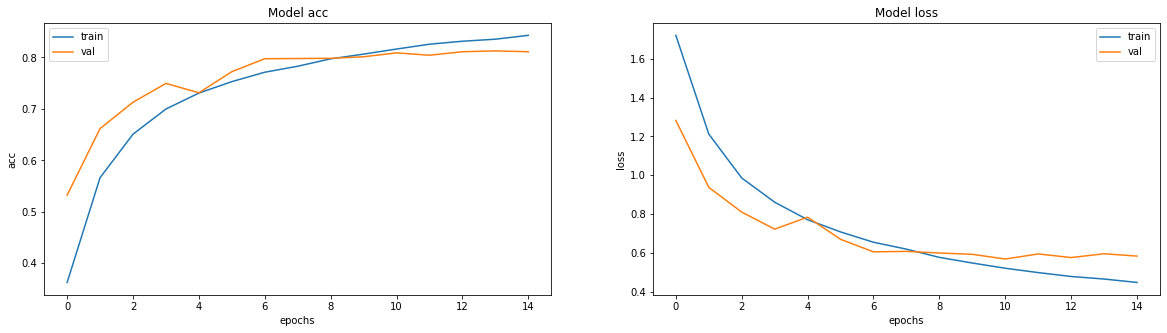

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model_cnn.history.history[metric])
    ax[i].plot(model_cnn.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## **Step 5: Evaluate model performance** (5 points)
- call the .evaluate() method on your model (model_cnn) with Xtest and ytest (one_hot_coded version)
- print the test loss and accuracy

In [10]:
#2-3 lines of code
score = model_cnn.evaluate(Xtests, ytests, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6402623057365417
Test accuracy: 0.7983999848365784


## **Step 6a: Interpret the model** (5 points)
- Compute confusion matrix and AUC

In [11]:
# 3-5 lines of code
ytest_pred = np.argmax(model_cnn.predict(Xtests),axis=-1)

cm = confusion_matrix(ytest,ytest_pred)
print('Confusion matrix on test set')
print(cm)
auc = roc_auc_score(ytests, model_cnn.predict(Xtests))
print('AUC on test set = ', auc)

Confusion matrix on test set
[[889   8  10   3   6   0   3   8  42  31]
 [ 12 883   1   1   2   2   3   1  20  75]
 [ 96   0 636  34  70  51  74  17  12  10]
 [ 42   6  38 594  39 139  80  31  18  13]
 [ 28   1  29  58 747  30  56  41   7   3]
 [ 16   4  35 136  33 715  20  26   8   7]
 [ 11   3  19  29  13   8 899   3   9   6]
 [ 25   1  16  29  44  47   4 806   5  23]
 [ 49  16   2   2   0   1   4   3 900  23]
 [ 23  33   2   5   2   1   3   1  15 915]]
AUC on test set =  0.9761433222222221


## **Step 6b: What mistakes does the model make?** (5 points)

In [12]:
incorrect_indices = np.nonzero(ytest_pred != ytest)[0]
print('Classified ', incorrect_indices.shape[0], ' images incorrectly in test set (10000 images).')

Classified  2016  images incorrectly in test set (10000 images).


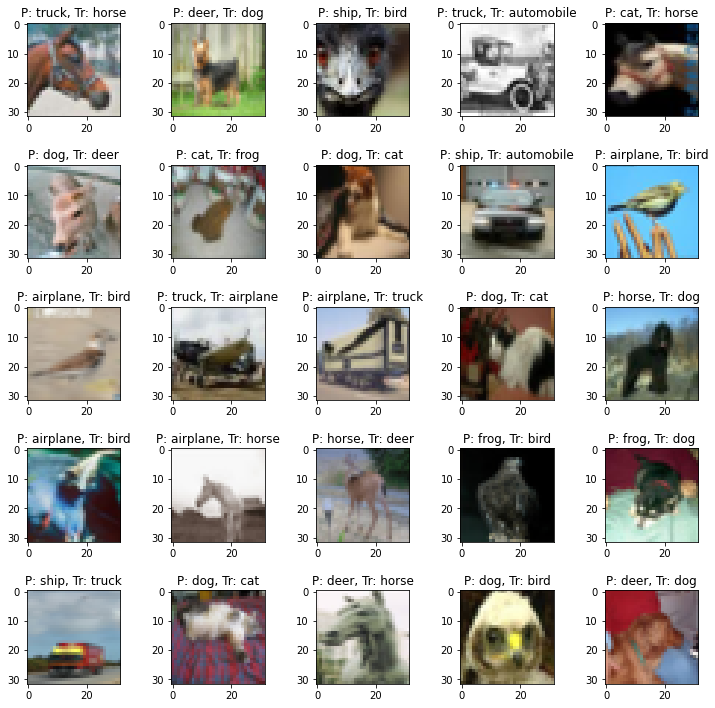

In [13]:
# Check which images the model go wrong
# store the indices from Xtest in incorrect_indices

# then visualize 25 of them using the code below

plt.figure(figsize=(10,10))
for i, incorrect in enumerate(incorrect_indices[:25]):
    plt.subplot(5,5,i+1)
    plt.imshow(Xtest[incorrect], interpolation='none')
    plt.title("P: {}, Tr: {}".format(class_names[ytest_pred[incorrect]], class_names[ytest[incorrect]]))
plt.tight_layout()

## **Step 7: Build a Gradcam activation map for incorrectly predicted images** (10 points)
### optional

In [14]:
correct_indices = np.nonzero(ytest_pred == ytest)[0]
print('Classified ', correct_indices.shape[0], ' images correctly in test set (10000 images).')

Classified  7984  images correctly in test set (10000 images).


In [15]:
%pip install tf-keras-vis
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

Text(0.5, 1.0, 'Actual: cat Predicted: cat')

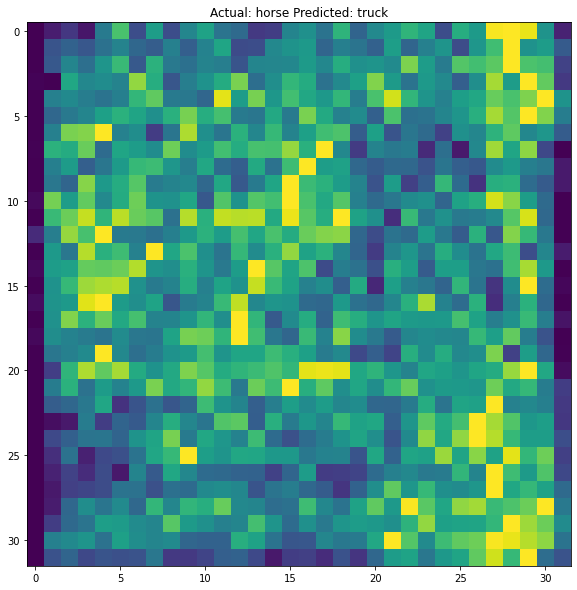

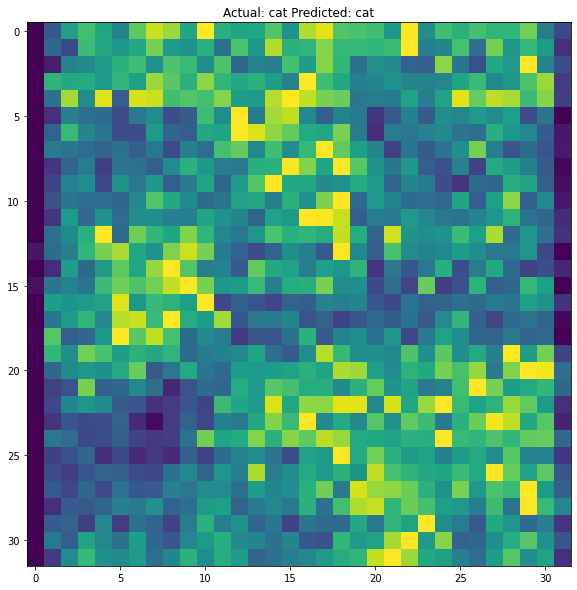

In [16]:
def loss(output):
    return tuple([output[0][digit] for digit in range(10)])

# get activations prior to softmax
def model_modifier(m):
    m.layers[-1].activation = tensorflow.keras.activations.linear
    return m

# Create Saliency object.
saliency = Saliency(model_cnn, model_modifier=model_modifier,clone=False)

img_num = 0
mistaken_img = Xtests[incorrect_indices[img_num]].reshape(1,32,32,3).astype('float32')
correct_img = Xtests[correct_indices[img_num]].reshape(1,32,32,3).astype('float32')


# Generate saliency map for mistake
saliency_map_mistake = saliency(loss,mistaken_img,smooth_samples=20,smooth_noise=0.20).reshape(32,32)
saliency_map_mistake = normalize(saliency_map_mistake)

plt.figure(figsize=(10,10))
plt.imshow(saliency_map_mistake)
plt.title('Actual: ' + class_names[ytest[incorrect_indices[img_num]]] + ' Predicted: ' + class_names[ytest_pred[incorrect_indices[img_num]]])

# Generate saliency map for correct
plt.figure(figsize=(10,10))
saliency_map_correct = saliency(loss,correct_img,smooth_samples=20,smooth_noise=0.20).reshape(32,32)
saliency_map_correct = normalize(saliency_map_correct)

plt.imshow(saliency_map_correct)
plt.title('Actual: ' + class_names[ytest[correct_indices[img_num]]] + ' Predicted: ' + class_names[ytest[correct_indices[img_num]]])

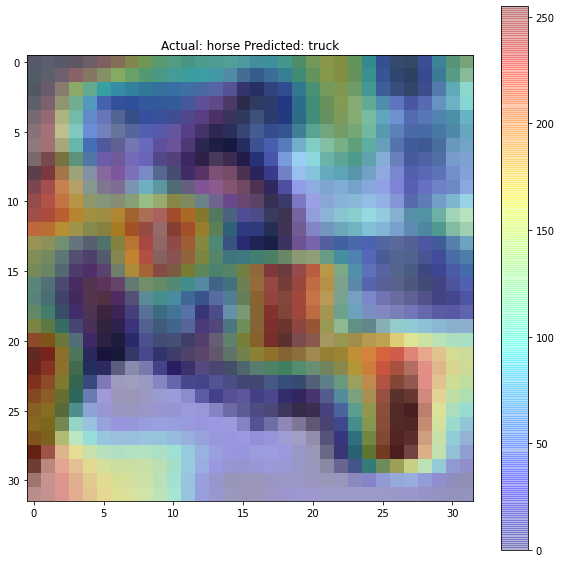

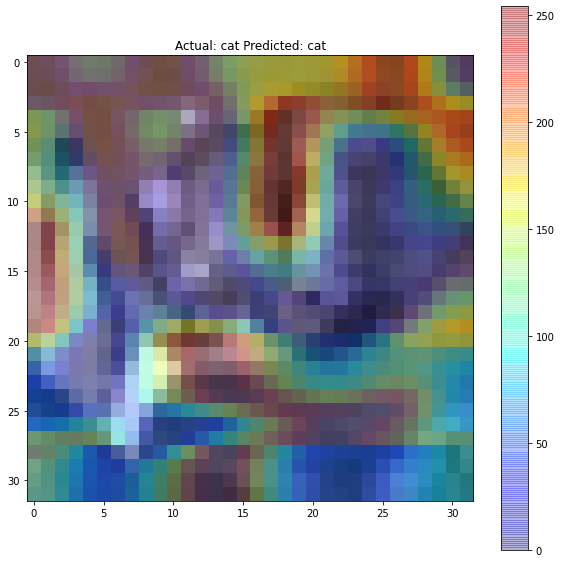

In [17]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam, GradcamPlusPlus

img_num = 0
mistaken_img = Xtests[incorrect_indices[img_num]].reshape(1,32,32,3).astype('float32')
correct_img = Xtests[correct_indices[img_num]].reshape(1,32,32,3).astype('float32')

# Create Gradcam object
gradcam = GradcamPlusPlus(model_cnn,model_modifier=model_modifier,clone=False)

# Generate heatmap with GradCAM
cam_mistake = gradcam(loss,mistaken_img,
              penultimate_layer=-1, # model.layers number
             ).reshape(32,32)
cam_mistake = normalize(cam_mistake)

plt.figure(figsize=(10,10))
plt.title('Actual: ' + class_names[ytest[incorrect_indices[img_num]]] + ' Predicted: ' + class_names[ytest_pred[incorrect_indices[0]]])
plt.imshow(Xtest[incorrect_indices[img_num]])
plt.imshow((cam_mistake*255).astype('uint8'),cmap='jet',alpha=0.3) 
plt.colorbar()

# Generate heatmap with GradCAM
cam_correct = gradcam(loss,correct_img,
              penultimate_layer=-1, # model.layers number
             ).reshape(32,32)
cam_correct = normalize(cam_correct)
plt.figure(figsize=(10,10))
plt.title('Actual: ' + class_names[ytest[correct_indices[img_num]]] + ' Predicted: ' + class_names[ytest_pred[correct_indices[0]]])
plt.imshow(Xtest[correct_indices[img_num]])
plt.imshow((cam_correct*255).astype('uint8'),cmap='jet',alpha=0.3) 
plt.colorbar()